# Pathway Evaluation
The goal is to analyse the behaviour of the different pathway when they are fed with the chosen substrate Methanol. They are judged by their maximum production and the maximum MA flux in relation to the biomass growth rate.

In [1]:
# Importing used packages and model
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
import pandas as pd
import matplotlib.pyplot as plt
model = read_sbml_model('../src/models/gen/iMT1026-v3.1.xml')
%run -i create_pathway.ipynb
# flux unit is mmol / [gDW h]

In [2]:
# path_selector legend
# 0 -> no additional reactions
#1 -> beta alanine pathway  
#2 -> transferase malonyl-CoA pathway  
#3 -> oxidoreuctive malonyl-CoA pathway
#4 -> lactate pathway  
#create_pathway(model,3)  # self-built function create_pathway(model, path_selector), that adds pathway

beta_model = create_pathway(model.copy(),1)
trn_malonyl_model = create_pathway(model.copy(),2)
red_malonyl_model = create_pathway(model.copy(),3)
lactate_model = create_pathway(model.copy(),4)
# saving all the models in a list made up of tuples with their name, in order to use them in loops later. This reduces the necessary code in the  evaluation.
models = [(beta_model,'Beta-Alanine'),(trn_malonyl_model,'Malonyl-CoA Transferase'),(red_malonyl_model,'Malonyl-CoA Oxidored'),(lactate_model,'Lactate')]

Added beta alanine pathway
Added trans malonyl-CoA pathway
Added red malonyl-CoA pathway
Added lactate pathway


### Medium for evaluation
The medium is set once and used for all the evaluation of the pathways to gurantee comparable results. The carbon source is changed from the model default of glycerol to methanol. The methanol uptake flux is set to a realistic value from cf.Tomàs‐Gamisans 2018.

In [3]:
# General medium for all models based on the unchanged vanilla model (=same medium as in all derived models)
medium = model.medium
medium['Ex_meoh'] = 6  # 6 = Realistic methanol uptake rates cf.Tomàs‐Gamisans 2018
medium['Ex_glyc'] = 0
med_names = dict()
for flux in medium:
    meta = model.reactions.get_by_id(flux).metabolites
    for element in meta:
        med_names[flux] = element.name
df_med = pd.DataFrame(medium, index=['uptake'])
df_names = pd.DataFrame(med_names, index=['name'])
display(pd.concat([df_names,df_med]))

,Ex_h2o,Ex_nh4,Ex_pi,Ex_h,Ex_o2,Ex_so4,Ex_glyc,Ex_fe2,Ex_btn,Ex_k,Ex_meoh
name,H2O,Ammonium,Phosphate,H+,Oxygen,Sulfate,Glycerol,Fe2+,Biotin,potassium,Methanol
uptake,1000,1000,1000,1000,1000,1000,0,1000,4e-05,1000,6


## Simulating pathways and visualizing results
The pathways are one by one simulated with the set medium flux. They are analyzed for maximum malonic acid production in relation to the biomass growth. The phenotypic phase planes show the relation of the carbon yield for malonic acid on methanol as a function of the growth rate.

General maximum biomass growth 0.0951 mmol/gDW*h


,Beta-Alanine,Malonyl-CoA Transferase,Malonyl-CoA Oxidored,Lactate
Maximum,,,,
carbon yield,1.0,1.0,0.982837,0.881316
MA flux in mmol/gDW*h,2.0,2.0,1.965673,1.762632


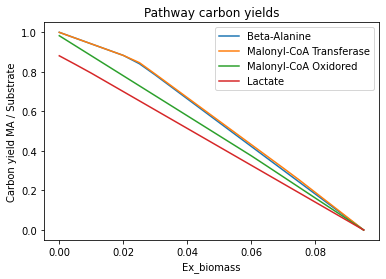

In [4]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope

model.medium = medium
model.objective = model.reactions.get_by_id('Ex_biomass')

df_yields = pd.DataFrame()
df_max = pd.DataFrame(index=['carbon yield','MA flux in mmol/gDW*h'])
df_max.index.name = 'Maximum'
max_growth = model.slim_optimize()
print('General maximum biomass growth',round(max_growth,4),'mmol/gDW*h')

for pairing in models:
    pathway_model = pairing[0]
    with pathway_model:
        pathway_model.medium = medium
        pathway_model.objective = pathway_model.reactions.get_by_id('Ex_mln')
        ppp = production_envelope(pathway_model,
                    reactions='Ex_biomass',
                    objective='Ex_mln')
        df_yields[pairing[1]]=ppp.carbon_yield_maximum
        df_max[pairing[1]]=[ppp.carbon_yield_maximum.max(),ppp.flux_maximum.max()]

display(df_max)
df_yields['Ex_biomass'] = ppp.Ex_biomass
df_yields.plot(x='Ex_biomass', y=[pairing[1] for pairing in models], title='Pathway carbon yields').set_ylabel('Carbon yield MA / Substrate')
plt.savefig('../img/pathway_yields.png')

### Discussion
The graph shows the relation of the carbon yield of malonic acid per substrate (Cmol MA / Cmol MeOH) as a function of the biomass growth rate. The provided table furthermore gives the maximum values for all pathways as well as the maximum productivity. Those values are only theoretical possible, because they are optimized for zero growth rate, which would lead to a dying organism colony.  
The results show, that first of all the maximum yield of malonic acid is the highest for the beta-alanine and malonyl-CoA Transerase pathway. Also the phenotypic phase plane shows a better behaviour in the curvature. For the first two pathways, a smaller reduction over the increasing biomass growth rate is visible, before having a crack in the curvture and going down to the maximum growth rate with no malonic acid production.  
The results show that the first two pathways are preferable for malonic acid production and are further examined for strain improvements.

# Evaluating optimal O2 uptake
The 2 most promising pathways, beta-alanine and malonyl-coa, are further analysed for their O2 uptake. Since the supply with oxygen is often a limiting factor in fermentations, the information of optimal O2 uptake for the different objectives, growth and malonic acid production, is of great value.

In [5]:
# Defining new models variable, to only look at the 2 more efficient pathways
models2 = [models[0],models[1]]
# Initializing a dictionary and a dataframe to collect the calculated values from the loops
cons_factor = 0.5  # factor of biomass growth for the constrained model
o2_uptake = dict()
df_values = pd.DataFrame(index=['MA production','biomass growth', 'MA constrained'])  # creating a dataframe for the maximum valeus with a predefined index to display them later
# To save codelines, a loop over the interesting pathways is created, as seen before in the other evaluations
for pairing in models2:
    pathway_model = pairing[0]
    df_pathway = pd.DataFrame()  # a data frame that collects the simulation results for the current pathway
    with pathway_model:
        pathway_model.medium = medium  # setting the medium (as before)
        # Obtaining values for malonic acid production
        pathway_model.objective = pathway_model.reactions.get_by_id('Ex_mln')
        ppp = production_envelope(pathway_model,      # a phentopyic phase plane evaluation for the O2 uptake of the current pathway
                    reactions='Ex_o2',
                    objective='Ex_mln')
        df_pathway['MA production']=ppp.flux_maximum  # saving values for the MA prod in the dataframe
        df_pathway['Ex_o2 MA'] = ppp.Ex_o2
        mln = (round(ppp.Ex_o2[ppp.flux_maximum.idxmax()],3),round(ppp.flux_maximum.max(),3))   # saving the maximum O2 uptake rate for MA of the current pathway
        
        # Obtaining values for biomass growth, same procedure as MA but different objective function
        pathway_model.objective = pathway_model.reactions.get_by_id('Ex_biomass')
        ppp = production_envelope(pathway_model,
                    reactions='Ex_o2',
                    objective='Ex_biomass')
        df_pathway['20xBiomass']=ppp.flux_maximum*20   # saving values for the biomass growth in a dataframe, multiplying them by 20 to make them more visible in the graph
        df_pathway['Ex_o2 bio'] = ppp.Ex_o2  # Adding the O2 values of the simulation for the x-axis for the plot
        bio = (round(ppp.Ex_o2[ppp.flux_maximum.idxmax()],3), round(ppp.flux_maximum.max(),3))
        max_growth = ppp.flux_maximum.max()
        
        # Obtaining values for constrained biomass growth, same procedure as MA but different objective function
        constrained_growth = pathway_model.problem.Constraint(
            pathway_model.reactions.Ex_biomass.flux_expression,
            lb=max_growth*cons_factor)
        pathway_model.add_cons_vars(constrained_growth)
        pathway_model.objective = pathway_model.reactions.get_by_id('Ex_mln')
        ppp = production_envelope(pathway_model,
                    reactions='Ex_o2',
                    objective='Ex_mln')
        df_pathway['MA constrained']=ppp.flux_maximum  # saving values for the biomass growth in a dataframe, multiplying them by 20 to make them more visible in the graph
        df_pathway['Ex_o2 MA cons'] = ppp.Ex_o2        # Adding the meoh values of the simulation for the x-axis for the plot
        ma_cons = (round(ppp.Ex_o2[ppp.flux_maximum.idxmax()],3),round(ppp.flux_maximum.max(),3))

        # carrying all the obtained results out of the loop and with environment by saving them in a data frame or dictionary with the pathway name as key
        df_values[pairing[1]] = [mln,bio,ma_cons]  # saving the o2 uptake rate at the maximum production/growth as a list
        o2_uptake[pairing[1]] = df_pathway

print('Optimum O2 uptake & production/growth at that point')
display(df_values)               

Optimum O2 uptake & production/growth at that point


,Beta-Alanine,Malonyl-CoA Transferase
MA production,"(-5.094, 1.953)","(-5.094, 1.953)"
biomass growth,"(-5.528, 0.093)","(-5.528, 0.093)"
MA constrained,"(-5.132, 1.107)","(-4.911, 1.139)"


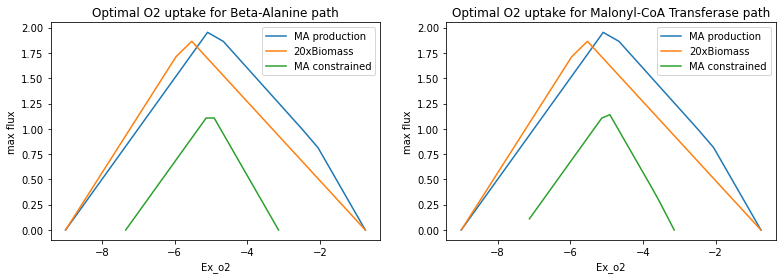

In [6]:
# Plotting the results
# Plot style 1
num_models = len(o2_uptake.keys())  # save the number of pathways analyzed for meoh production
fig, ax = plt.subplots(1, 2, sharey = False) # creating a subplot of the dimension 1x2
fig.set_figwidth(13)  # increasing readability by setting width
#fig.set_figheight(10)
for num in range(num_models):   # creating a loop that uses a range to index over all models contained in meOh uptake to match each subplot field with a model
    # ax[num].rcParams['figure.figsize'] = [10, 4]
    ax[num].plot(o2_uptake[models[num][1]]['Ex_o2 MA'], o2_uptake[models[num][1]]['MA production'], label='MA production')   # plotting the MA Production for the respeective model
    ax[num].plot(o2_uptake[models[num][1]]['Ex_o2 bio'], o2_uptake[models[num][1]]['20xBiomass'], label='20xBiomass')   # plotting the biomass growth for the respeective model
    ax[num].plot(o2_uptake[models[num][1]]['Ex_o2 MA cons'], o2_uptake[models[num][1]]['MA constrained'], label='MA constrained')   # plotting the biomass growth for the respeective model
    # setting the correct labels and title and shwoing the legend for the subplots
    ax[num].set_ylabel('max flux')
    ax[num].set_xlabel('Ex_o2')
    ax[num].set_title('Optimal O2 uptake for '+models[num][1]+' path')
    ax[num].legend()
    
plt.savefig('../img/o2_uptake.png')

### Discussion
The results for the two pathways for the oxygen dependency are equal. Both the malonic acid production and the biomass growth rate seem to have the same oxygen dependency for both pathways.  
Interestingly the oxygen demand varys between the two objectives malonic acid producation and biomass growth. The optimal uptake is slightly higher for the biomass growth. Also a difference in the curvature is visible. Furthermore a constrained simulation has been conducted where the growth was set to 50% of the maximum growth on 6 mmol/gDW\*h methanol and no oxygen limitation. Under this boundary conditions, malonic acid is only produced after an O2 uptake rate of >~ 3 mmol/gDW\*h and reaches less production, because of the parallel growth. The peak of maximum production is shifted and a slight difference between the two pathways is noted.  
  
It can be seen that the malonic acid and the biomass are having influence on the optimum and the optimal uptake rate has to be determined for a previoulsy fixed or targeted biomass growth rate.

# Ideal maximum methanol uptake
Analyse for the theoretically best methanol concentration for both growth an malonic acid production

In [7]:
# Definin new medium with high meoh concentration to see the behaviour over a wide range of uptake rates
medium2 = model.medium
medium2['Ex_meoh'] = 1000  # 6 = Realistic methanol uptake rates cf.Tomàs‐Gamisans 2018
medium2['Ex_glyc'] = 0

In [18]:
# Using the same code as for the O2 uptake evaluation but supstituting the reaction of the ppp production_envelope from O2 to MeOH
# Defining new models variable, to only look at the 2 more efficient pathways
models2 = [models[0],models[1]]
# Initializing a dictionary and a dataframe to collect the calculated values from the loops
meoh_uptake = dict()
df_values = pd.DataFrame(index=['MA production','biomass growth'])  # creating a dataframe for the maximum valeus with a predefined index to display them later
# To save codelines, a loop over the interesting pathways is created, as seen before in the other evaluations
for pairing in models2:
    pathway_model = pairing[0]
    df_pathway = pd.DataFrame()  # a data frame that collects the simulation results for the current pathway
    with pathway_model:
        pathway_model.medium = medium2  # setting the medium (as before)
        # Obtaining values for malonic acid production
        pathway_model.objective = pathway_model.reactions.get_by_id('Ex_mln')
        ppp = production_envelope(pathway_model,      # a phentopyic phase plane evaluation for the meoh uptake of the current pathway
                    reactions='Ex_meoh',
                    objective='Ex_mln')
        df_pathway['MA production']=ppp.flux_maximum  # saving values for the MA prod in the dataframe
        df_pathway['Ex_meoh MA'] = ppp.Ex_meoh
        mln=(round(ppp.Ex_meoh[ppp.flux_maximum.idxmax()],2),round(ppp.flux_maximum.max(),2))   # saving the maximum meoh uptake rate for MA of the current pathway

        # Obtaining values for biomass growth, same procedure as MA but different objective function
        pathway_model.objective = pathway_model.reactions.get_by_id('Ex_biomass')
        ppp = production_envelope(pathway_model,
                    reactions='Ex_meoh',
                    objective='Ex_biomass')
        df_pathway['20xBiomass']=ppp.flux_maximum*20   # saving values for the biomass growth in a dataframe, multiplying them by 20 to make them more visible in the graph
        df_pathway['Ex_meoh bio'] = ppp.Ex_meoh
        bio = (round(ppp.Ex_meoh[ppp.flux_maximum.idxmax()],2),round(ppp.flux_maximum.max(),2))
       
        # carrying all the obtained results out of the loop and with environment by saving them in a data frame or dictionary with the pathway name as key
        df_values[pairing[1]] = [mln,bio]  # saving the meoh uptake rate at the maximum production/growth as a list
        meoh_uptake[pairing[1]] = df_pathway
        #display(df_pathway)

print('Optimum MeOH uptake in mmol/(gDW*h)')
display(df_values)

Optimum MeOH uptake in mmol/(gDW*h)


,Beta-Alanine,Malonyl-CoA Transferase
MA production,"(-742.79, 247.6)","(-742.79, 247.6)"
biomass growth,"(-594.33, 9.03)","(-594.33, 9.03)"


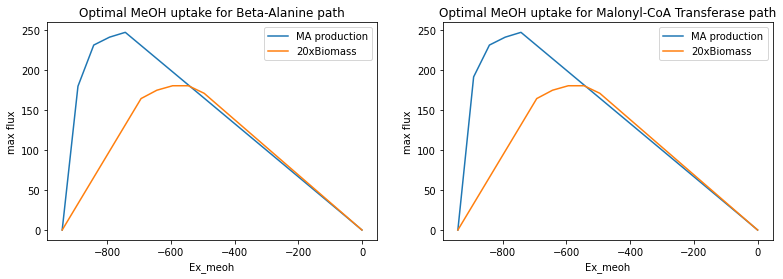

In [16]:
# Plotting the results
# Plot style 1
num_models = len(meoh_uptake.keys())  # save the number of pathways analyzed for meoh production
fig, ax = plt.subplots(1, 2, sharey = False) # creating a subplot of the dimension 1x2
fig.set_figwidth(13)  # increasing readability by setting width

for num in range(num_models):   # creating a loop that uses a range to index over all models contained in meOh uptake to match each subplot field with a model
    # ax[num].rcParams['figure.figsize'] = [10, 4]
    ax[num].plot(meoh_uptake[models[num][1]]['Ex_meoh MA'], meoh_uptake[models[num][1]]['MA production'], label='MA production')   # plotting the MA Production for the respeective model
    ax[num].plot(meoh_uptake[models[num][1]]['Ex_meoh bio'], meoh_uptake[models[num][1]]['20xBiomass'], label='20xBiomass')   # plotting the biomass growth for the respeective model
    # setting the correct labels and title and shwoing the legend for the subplots
    ax[num].set_ylabel('max flux')
    ax[num].set_xlabel('Ex_meoh')
    ax[num].set_title('Optimal MeOH uptake for '+models[num][1]+' path')
    ax[num].legend()

fig.savefig('../img/meoh_uptake.png')

### Discussion
The results show that also here both pathways have the same dynamics for both objectives, malonic acid producation and biomass growth. It is noted, theat the maximum flux of malonic acid production is at a higher uptake rate than biomass growth. The graphs compare both fluxes, but the growth rate was multiplied with a factor of 20 to put the fluxes in the same range as the ones of the malonic acid growth. This means that the differences are much smaller than they look for the growth rate. It can be seen, that the malonic acid flux is about a third of the methanol uptake rate until the maximum is reached. This is the same relation as for the amount of carbon atoms between the two molecules.  
  
It is interesting to see that a carbon source repression seems to happen after the maximum is reached. The exact reason for this phenomena is not clear, since no other substrate is limiting the production. The repressions seems to be stronger for the growth rate than for the malonic acid production. Furthermore, the production and growth rate doesnt level off, but decrease back to zero eventually, which would mean that the cells die at to high methanol uptake fluxes.  
  
Furthermore it has to be noted, that the physically possible upatake rates are at very small values. CITATION found an uptake rate of 6 mmol/gDW\*h, which was also used for most of the evaluations. Therefore the repression through methanol is outside of a reachable uptake rate and poses no concern for the derived phenotypes. But the evaluation shows, that a linear increase of production can be achieved through an upregulation of the methanol uptake capabilities.

# Evaluating for minimal medium
In this section the minimal fluxes to achieve the specified growth or malonic acid production are obtained.  This way the medium is analysed for essential components and their quantative uptake, in order to identify possible limiting factors.

In [10]:
from cobra.medium import minimal_medium
print(medium)

{'Ex_h2o': 1000.0, 'Ex_nh4': 1000.0, 'Ex_pi': 1000.0, 'Ex_h': 1000.0, 'Ex_o2': 1000.0, 'Ex_so4': 1000.0, 'Ex_glyc': 0, 'Ex_fe2': 1000.0, 'Ex_btn': 4e-05, 'Ex_k': 1000.0, 'Ex_meoh': 6}


### Analyzing for biomass growth
The medium is anaylsed for essential components for the biomass growth.

In [11]:
# for biomass growth
df_med_bio = pd.DataFrame()   # creating data frame for better visualization

for pairing in models2:
    pathway_model = pairing[0]
    with pathway_model:
        pathway_model.medium = medium  # setting medium for model
        max_growth = pathway_model.slim_optimize()
        min_med=minimal_medium(pathway_model, max_growth)  # evaluating the minimal medium to achive the biomass growth in the model
        min_med['biomass growth'] = max_growth  # saving the growth in the same data series
        df_med_bio[pairing[1]+' bio'] = min_med   # saving the generated result in the data frame under the pathway name
        
#display(df_med_bio)

### Analyzing for malonic acid production
The medium is anaylsed for essential components for the production of malonic acid.

In [12]:
# for malonic acid production growth
df_med_mln = pd.DataFrame()

for pairing in models2:
    pathway_model = pairing[0]
    with pathway_model:
        pathway_model.medium = medium
        pathway_model.objective = pathway_model.reactions.get_by_id('Ex_mln')
        max_production = pathway_model.slim_optimize()
        min_med = minimal_medium(pathway_model, max_production)
        min_med['MA production'] = max_production
        df_med_mln[pairing[1]+' MA'] = min_med
        
#display(df_med_mln)

### Results
The computed minimal medium composition and fluxes are compared against each other and graphically displayed.

,Ex_nh4,Ex_pi,Ex_o2,Ex_so4,Ex_meoh,biomass growth,MA production
Beta-Alanine bio,0.59,0.0239,5.6239,0.0042,6.0,0.0951,NaN
Malonyl-CoA Transferase bio,0.59,0.0239,5.6239,0.0042,6.0,0.0951,NaN
Beta-Alanine MA,NaN,NaN,5.0000,NaN,6.0,NaN,2.0
Malonyl-CoA Transferase MA,NaN,NaN,5.0000,NaN,6.0,NaN,2.0


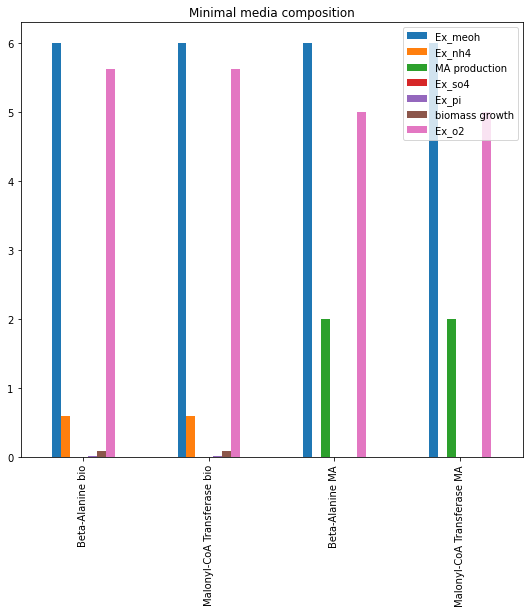

In [25]:
transpose=pd.concat([round(df_med_bio.T,4), round(df_med_mln.T,4)])
display(transpose)
arguments = list(set(list(df_med_bio.index) + list(df_med_mln.index)))
#arguments = ['Ex_o2', 'Ex_nh4', 'Ex_pi', 'Ex_so4']
transpose.plot(y= arguments, kind='bar', figsize=(9,8), title = 'Minimal media composition')
plt.savefig('../img/minimal_medium.png')

### Discussion
As seen in the results, the medium only needs a few components to ensure the growth and production. In general the substrate is the limitation in both cases. Further it has to be noticed, that the demands to the medium are much lower for the malonic acid production, which theoretically only needs the carbon source and oxygen to work.  
Nevertheless, it has to be noted, that several compounds are deemed as unnecessary which has to be seen critical. First and foremost the complex additive Biotin doesnt seem to effect the growth or malic acid production in any way, while it is known to be vital to yeast organisms.